In [30]:
# !pip install tensorflow

In [31]:
# !pip install tensorflow-addons

In [32]:
# !pip install imageio

In [33]:
# !pip install librosa

In [34]:
# !pip install Ipython

In [35]:
import librosa

import numpy as np
import pandas as pd
import os

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers

import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
from IPython.display import clear_output

from tqdm.notebook import tqdm

import glob
import imageio
import time

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [36]:
seed=111
tf.compat.v1.set_random_seed(seed)

session_config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
session = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_config)

tf.compat.v1.keras.backend.set_session(session)

In [37]:
# Seperating the training and testing data
# Dataset already contains an 75-25 split of training and testing (check the csv file for details)

# Read the CSV file
df = pd.read_csv('/Users/vamsi/Desktop/Learning/Autoencoder anomaly detection/data-warblr/warblrb10k_public_metadata.csv')

# Create lists for train and test datasets
train_files = [] # Contains paths of all files needed for training
test_files = []  # Contains paths of all files needed for testing

# Iterate over the DataFrame
for index, row in tqdm(df.iterrows()):
    itemid = row['itemid']
    hasbird = row['hasbird']
    
    # Define the path of the audio file
    file_path = os.path.join('/Users/vamsi/Desktop/Learning/Autoencoder anomaly detection/data-warblr/wav', f'{itemid}.wav')  # replace .wav with your audio file extension
    
    # If hasbird is 1, add the file to the train list
    if hasbird == 1:
        train_files.append(file_path)
    # Else, add the file to the test list
    else:
        test_files.append(file_path)

# print(len(train_files))
# print(len(test_files))

0it [00:00, ?it/s]

6045
/Users/vamsi/Desktop/Learning/Autoencoder anomaly detection/data-warblr/wav\1d94fc4a-1c63-4da0-9cac.wav
1955


In [38]:
# Training and validation parameters

train_size = 6045
BATCH_SIZE = 15
test_size = 1955
epochs = 20

latent_dim = 2 # Dimensions of latent space for visualisation
num_examples_to_generate = 10 # Example generated outputs

In [39]:
# Function to load files

def load(file):
    data, sampling_rate = librosa.load(file, sr=None, offset=0.0, duration=10)
    data = data.reshape(1,-1)
    return data

map_data = lambda filename: tf.compat.v1.py_func(load, [filename], [tf.float32])

In [40]:
# Sampling original music

sample = train_files[1]
sample, sampling_rate = librosa.load(sample, sr=None, offset=0.0, duration=10)
ipd.Audio(sample, rate=sampling_rate)

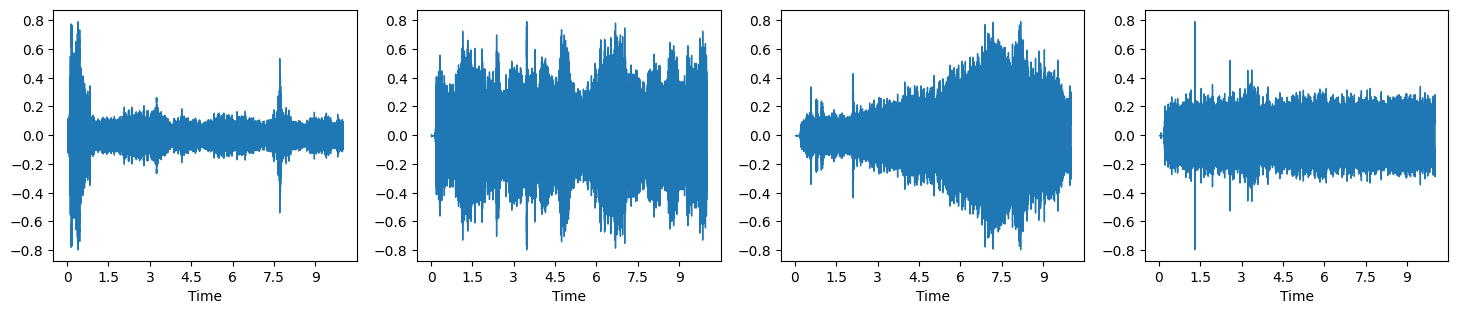

In [43]:
# Displaying the amplitude envelopes of examples from training data

plt.figure(figsize=(18, 15))
for i in range(4):
    plt.subplot(4, 4, i+1)
    j = load(train_files[i])
    librosa.display.waveshow(j[0], sr=sampling_rate)

In [45]:
# Creating tensors from training and testing data

train_dataset = (tf.data.Dataset.from_tensor_slices((train_files)).map(map_data, num_parallel_calls=AUTOTUNE).shuffle(3).batch(BATCH_SIZE))
test_dataset = (tf.data.Dataset.from_tensor_slices((test_files)).map(map_data, num_parallel_calls=AUTOTUNE).shuffle(3).batch(BATCH_SIZE))

In [ ]:
# Building the network